In [1]:
# Ensure you have a CUDA-compatible version of PyTorch installed.
!pip install -q ultralytics timm opencv-python Pillow

# Load CNN model

In [2]:
from ultralytics import YOLO

# The YOLO model from ultralytics will automatically use the GPU if available.
# We will explicitly specify the device during the inference call for clarity and certainty.
cnn = YOLO("models/cnn.pt")

# Load ViT model and move to GPU

In [3]:
import timm
import torch

# Define the device to use (CUDA or CPU). This is the standard practice.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create the model and move it to the defined device immediately.
vit = timm.create_model('eva02_base_patch14_224.mim_in22k', pretrained=False, num_classes=8).to(device)

# Load the model weights, mapping them to the same device to prevent errors.
vit.load_state_dict(torch.load("models/vit.pth", map_location=device))

# Set to evaluation mode. The model is already on the correct device.
vit.eval()

c:\Users\ochon\.conda\envs\naic\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


Eva(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (rope): RotaryEmbeddingCat()
  (blocks): ModuleList(
    (0-11): 12 x EvaBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): EvaAttention(
        (q_proj): Linear(in_features=768, out_features=768, bias=True)
        (k_proj): Linear(in_features=768, out_features=768, bias=False)
        (v_proj): Linear(in_features=768, out_features=768, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLU(
        (fc1_g): Linear(in_features=768, out_features=2048, bias=True)
        (fc1_x): Linear(in_features=76

In [4]:
from torchvision import transforms

# These transforms run on the CPU to prepare the image data before it's sent to the GPU.
vit_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load labels

In [5]:
with open('models/labels.txt') as f:
    labels = {i: line.strip().split(' ', 1)[1] for i, line in enumerate(f)}

print(labels)

{0: 'Kek Lapis', 1: 'Kuih Kaswi Pandan', 2: 'Kuih Ketayap', 3: 'Kuih Lapis', 4: 'Kuih Seri Muka', 5: 'Kuih Talam', 6: 'Kuih Ubi Kayu', 7: 'Onde-Onde'}


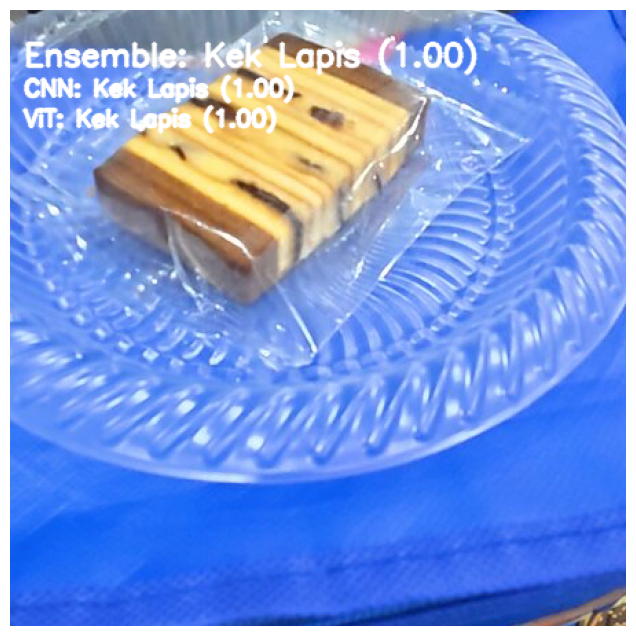

In [ ]:
import cv2
from PIL import Image
import torch
import torch.nn.functional as F
from collections import Counter
from threading import Thread
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np

num_classes = 8

# This CameraThread class correctly uses CPU-based libraries for capturing frames.
class CameraThread:
    def __init__(self, src=0):
        self.cap = cv2.VideoCapture(src)
        if not self.cap.isOpened():
            raise IOError(f"Cannot open webcam at index {src}. "
                          "Try a different index or check if the camera is used by another application.")

        self.cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
        self.cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        self.running = True
        self.frame = None
        self.thread = Thread(target=self.update, daemon=True)
        self.thread.start()

    def update(self):
        while self.running:
            ret, frame = self.cap.read()
            if ret:
                self.frame = frame
            else:
                self.running = False

    def read(self):
        return self.frame

    def release(self):
        self.running = False
        if self.thread.is_alive():
            self.thread.join()
        self.cap.release()
        print("Camera released.")

def center_crop(image, crop_width, crop_height):
    """
    Performs a center crop on an image.

    Args:
        image: The input image (as a NumPy array).
        crop_width: The desired width of the cropped image.
        crop_height: The desired height of the cropped image.

    Returns:
        The center-cropped image.
    """
    original_height, original_width, _ = image.shape

    # Calculate the center of the image
    center_x = original_width // 2
    center_y = original_height // 2

    # Calculate the starting and ending coordinates for the crop
    start_x = center_x - (crop_width // 2)
    end_x = start_x + crop_width
    start_y = center_y - (crop_height // 2)
    end_y = start_y + crop_height

    # Perform the crop using NumPy slicing
    cropped_image = image[start_y:end_y, start_x:end_x]

    return cropped_image

# --- Main Inference Loop ---
try:
    cam = CameraThread(src=1)
    print("Camera initialized.")
    time.sleep(2.0)
    print("Starting inference loop...")

    while True:
        frame = cam.read()
        if frame is None:
            time.sleep(0.1)
            continue

        frame = center_crop(frame, 448, 448)

        # --- 1. CNN Prediction (on GPU) ---
        cnn_results = cnn(frame, device=device, verbose=False)
        cnn_pred_classes = cnn_results[0].boxes.cls.tolist()

        if cnn_pred_classes:
            cnn_counts = Counter(cnn_pred_classes)
            cnn_probs = [cnn_counts.get(float(i), 0) for i in range(num_classes)]
            if sum(cnn_probs) > 0:
                cnn_probs = [p / sum(cnn_probs) for p in cnn_probs]
            cnn_predicted_class_idx = int(max(cnn_counts, key=cnn_counts.get))
        else:
            cnn_probs = [0.0] * num_classes
            cnn_predicted_class_idx = -1

        # --- 2. ViT Prediction (on GPU) ---
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)
        input_tensor = vit_transform(pil_image).unsqueeze(0).to(device)

        with torch.no_grad():
            vit_logits = vit(input_tensor)

        vit_probs_tensor = F.softmax(vit_logits, dim=1).squeeze(0).cpu()
        vit_probs = vit_probs_tensor.tolist()
        vit_predicted_class_idx = int(torch.argmax(vit_probs_tensor).item())

        # --- 3. Combine Predictions (Ensemble on CPU) ---
        final_probs = [(c + v) / 2 for c, v in zip(cnn_probs, vit_probs)]

        if cnn_predicted_class_idx == vit_predicted_class_idx and cnn_predicted_class_idx != -1:
            final_idx = cnn_predicted_class_idx
        else:
            final_idx = np.argmax(final_probs)

        final_label = labels.get(final_idx, 'Detecting...')
        cnn_label = labels.get(cnn_predicted_class_idx, 'Detecting...')
        vit_label = labels.get(vit_predicted_class_idx, 'Detecting...')

        # Get the probability scores for the predicted classes
        final_prob = final_probs[final_idx] if final_idx != -1 else 0
        cnn_prob = cnn_probs[cnn_predicted_class_idx] if cnn_predicted_class_idx != -1 else 0
        vit_prob = vit_probs[vit_predicted_class_idx] if vit_predicted_class_idx != -1 else 0

        # --- 4. Display the result on the frame (on CPU) ---
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.75
        color = (255, 255, 255)
        thickness = 2
        line_type = cv2.LINE_AA

        x = 10
        y_start = 40
        line_height = int(font_scale * 30)

        # Display predictions with their probabilities
        cv2.putText(frame, f'Ensemble: {final_label} ({final_prob:.2f})', (x, y_start), font, font_scale, color, thickness, line_type)
        cv2.putText(frame, f'CNN: {cnn_label} ({cnn_prob:.2f})', (x, y_start + line_height), font, font_scale-0.2, color, thickness, line_type)
        cv2.putText(frame, f'ViT: {vit_label} ({vit_prob:.2f})', (x, y_start + 2 * line_height), font, font_scale-0.2, color, thickness, line_type)

        # --- Display in Notebook (on CPU) ---
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        clear_output(wait=True)
        plt.figure(figsize=(8, 8))
        plt.imshow(frame_rgb)
        plt.axis('off')
        plt.show()

except (KeyboardInterrupt, IOError) as e:
    print(f"Stopping due to: {e}")
finally:
    if 'cam' in locals() and cam.cap.isOpened():
        cam.release()
    plt.close('all')